# Функции на Българската народна банка
## Text Mining Approach
Данните, които са използвани, съдържат документи, закони и устави, свързани с БНБ. Те са предварително разпределени в седем категории, обхващати основните функции на централната банка за периода (1879 - 1945 г.): 
* устройствени закони и устави на БНБ
* търговскобанкова функция
* емисионна фунцкия
* функция по провеждане на паричната политика
* функция на фискален агент
* регулаторна и надзорна фунцкия и други

Данните са предварително обработени: всички числа и често срещани и съюзни думи, които не предоставят информация (stopwords) са премахнати, главните букви са заменени с малки и всички думи са минали процес на *stemming*.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
from nltk import bigrams
import itertools
import collections
import networkx as nx
import nltk
import re

In [2]:
db = pd.read_pickle('dflaws.pkl')
db.head()

,Unnamed: 0,Year,Issue,Law,Text,Period,Function,Ruler
0,0,1879,0,1,проект устав бълг народн банк утвърд руск импе...,1,Устройствени закони и устави,Княз Корсаков
1,1,1879,0,1,инструкци дейност бълг народн банк нейн отдел ...,1,Устройствени закони и устави,Княз Корсаков
2,2,1879,0,1,приложени формуляр достоверени необходим цел и...,1,Устройствени закони и устави,Княз Александър I
3,3,1883,0,2,изда двор софи юлий александр приподпи минист ...,1,Устройствени закони и устави,0
4,4,1883,29,3,резулт надзор състав особ глав рапорт представ...,1,Устройствени закони и устави,Княз Александър I


# Wordclouds

Всички документи от сборника могат лесно да бъдат представени визуално чрез *облак от думи* (от англ. - wordcloud). Характерното за този тип визуализация е, че размерът и цветът на всяка дума в облака съответстват на честотата ѝ на използване и по-този начин се откроява лесно най-важната информация, съдържаща се във входящите данни. Тук това са морфемите *банк, дъжав, бълг и закон*, което показва, че те изграждат основата на всички закони и устави в сборника. Други често използвани морфеми, които се отличават, са *минист* и *финанс*, като така те ни подсказват за по-ниската степен на незавимост на централната банка от правителството, характерна за периода 1879 - 1945 г. Високата честотата на срещане на морфемите *банкнот*, *печа* и *лев* от своя страна ни насочват към и друга основна функция на централната банката, която за разлика от тази на фискален агент, ни е добре позната и днес - емисионната.

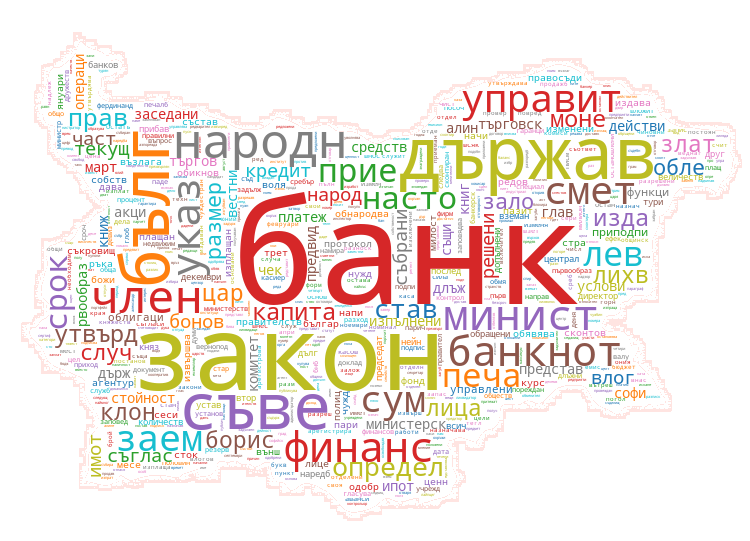

In [3]:
#join the text from all the documents into one long string
onestring = ','.join(list(db['Text']))
# Create a WordCloud object
bgmask = np.array(Image.open("bg.png"))
wordcloud = WordCloud(background_color="white", max_words=10000, 
                      mask = bgmask, contour_width=1, contour_color='mistyrose',
                      collocations = False, colormap='tab10')
# Generate a word cloud
wordcloud.generate(onestring)
# Visualize the word cloud
wordcloud.to_image()

In [4]:
bnbfunctions = db['Function'].unique()

# Wordcloud според различните функции
Тук визуализацията ни показва думите, характеризиращи различните функции (пр. банкнота - Емисионна).

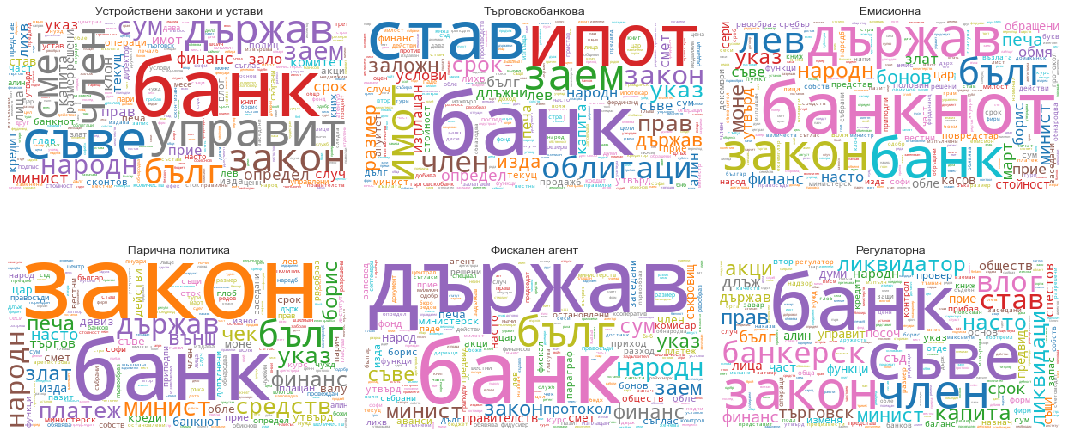

In [5]:
sns.set()
wordcloud = WordCloud(background_color="white", max_words=5000,
                      collocations = False, colormap='tab10')
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
for i in range(0, len(bnbfunctions)):
    dbf = db[db['Function']==bnbfunctions[i]]
    onestring = ','.join(list(dbf['Text']))
    wordcloud.generate(onestring)
    axes[int(i/3), i%3].imshow(wordcloud)
    axes[int(i/3), i%3].axis('off')
    axes[int(i/3), i%3].set_title(bnbfunctions[i])
    axes[int(i/3), i%3].set_xticklabels([])
    axes[int(i/3), i%3].set_yticklabels([])
    
plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

In [6]:
words = nltk.word_tokenize(''.join(str(db['Text'].tolist())).replace('\'',""))
bigramdf = pd.DataFrame(pd.Series(nltk.ngrams(words, 2)).value_counts(), columns=['count'])
bigramdf['bigram'] = bigramdf.index
bigramdf = bigramdf.reset_index()
bigramdf = bigramdf.drop('index', axis=1)
bigramdf  = bigramdf.iloc[:150, :]

# Bigrams Correlation Netowrk
Ясно виждаме двете *ядра* при мрежата от думи: банка и указ.

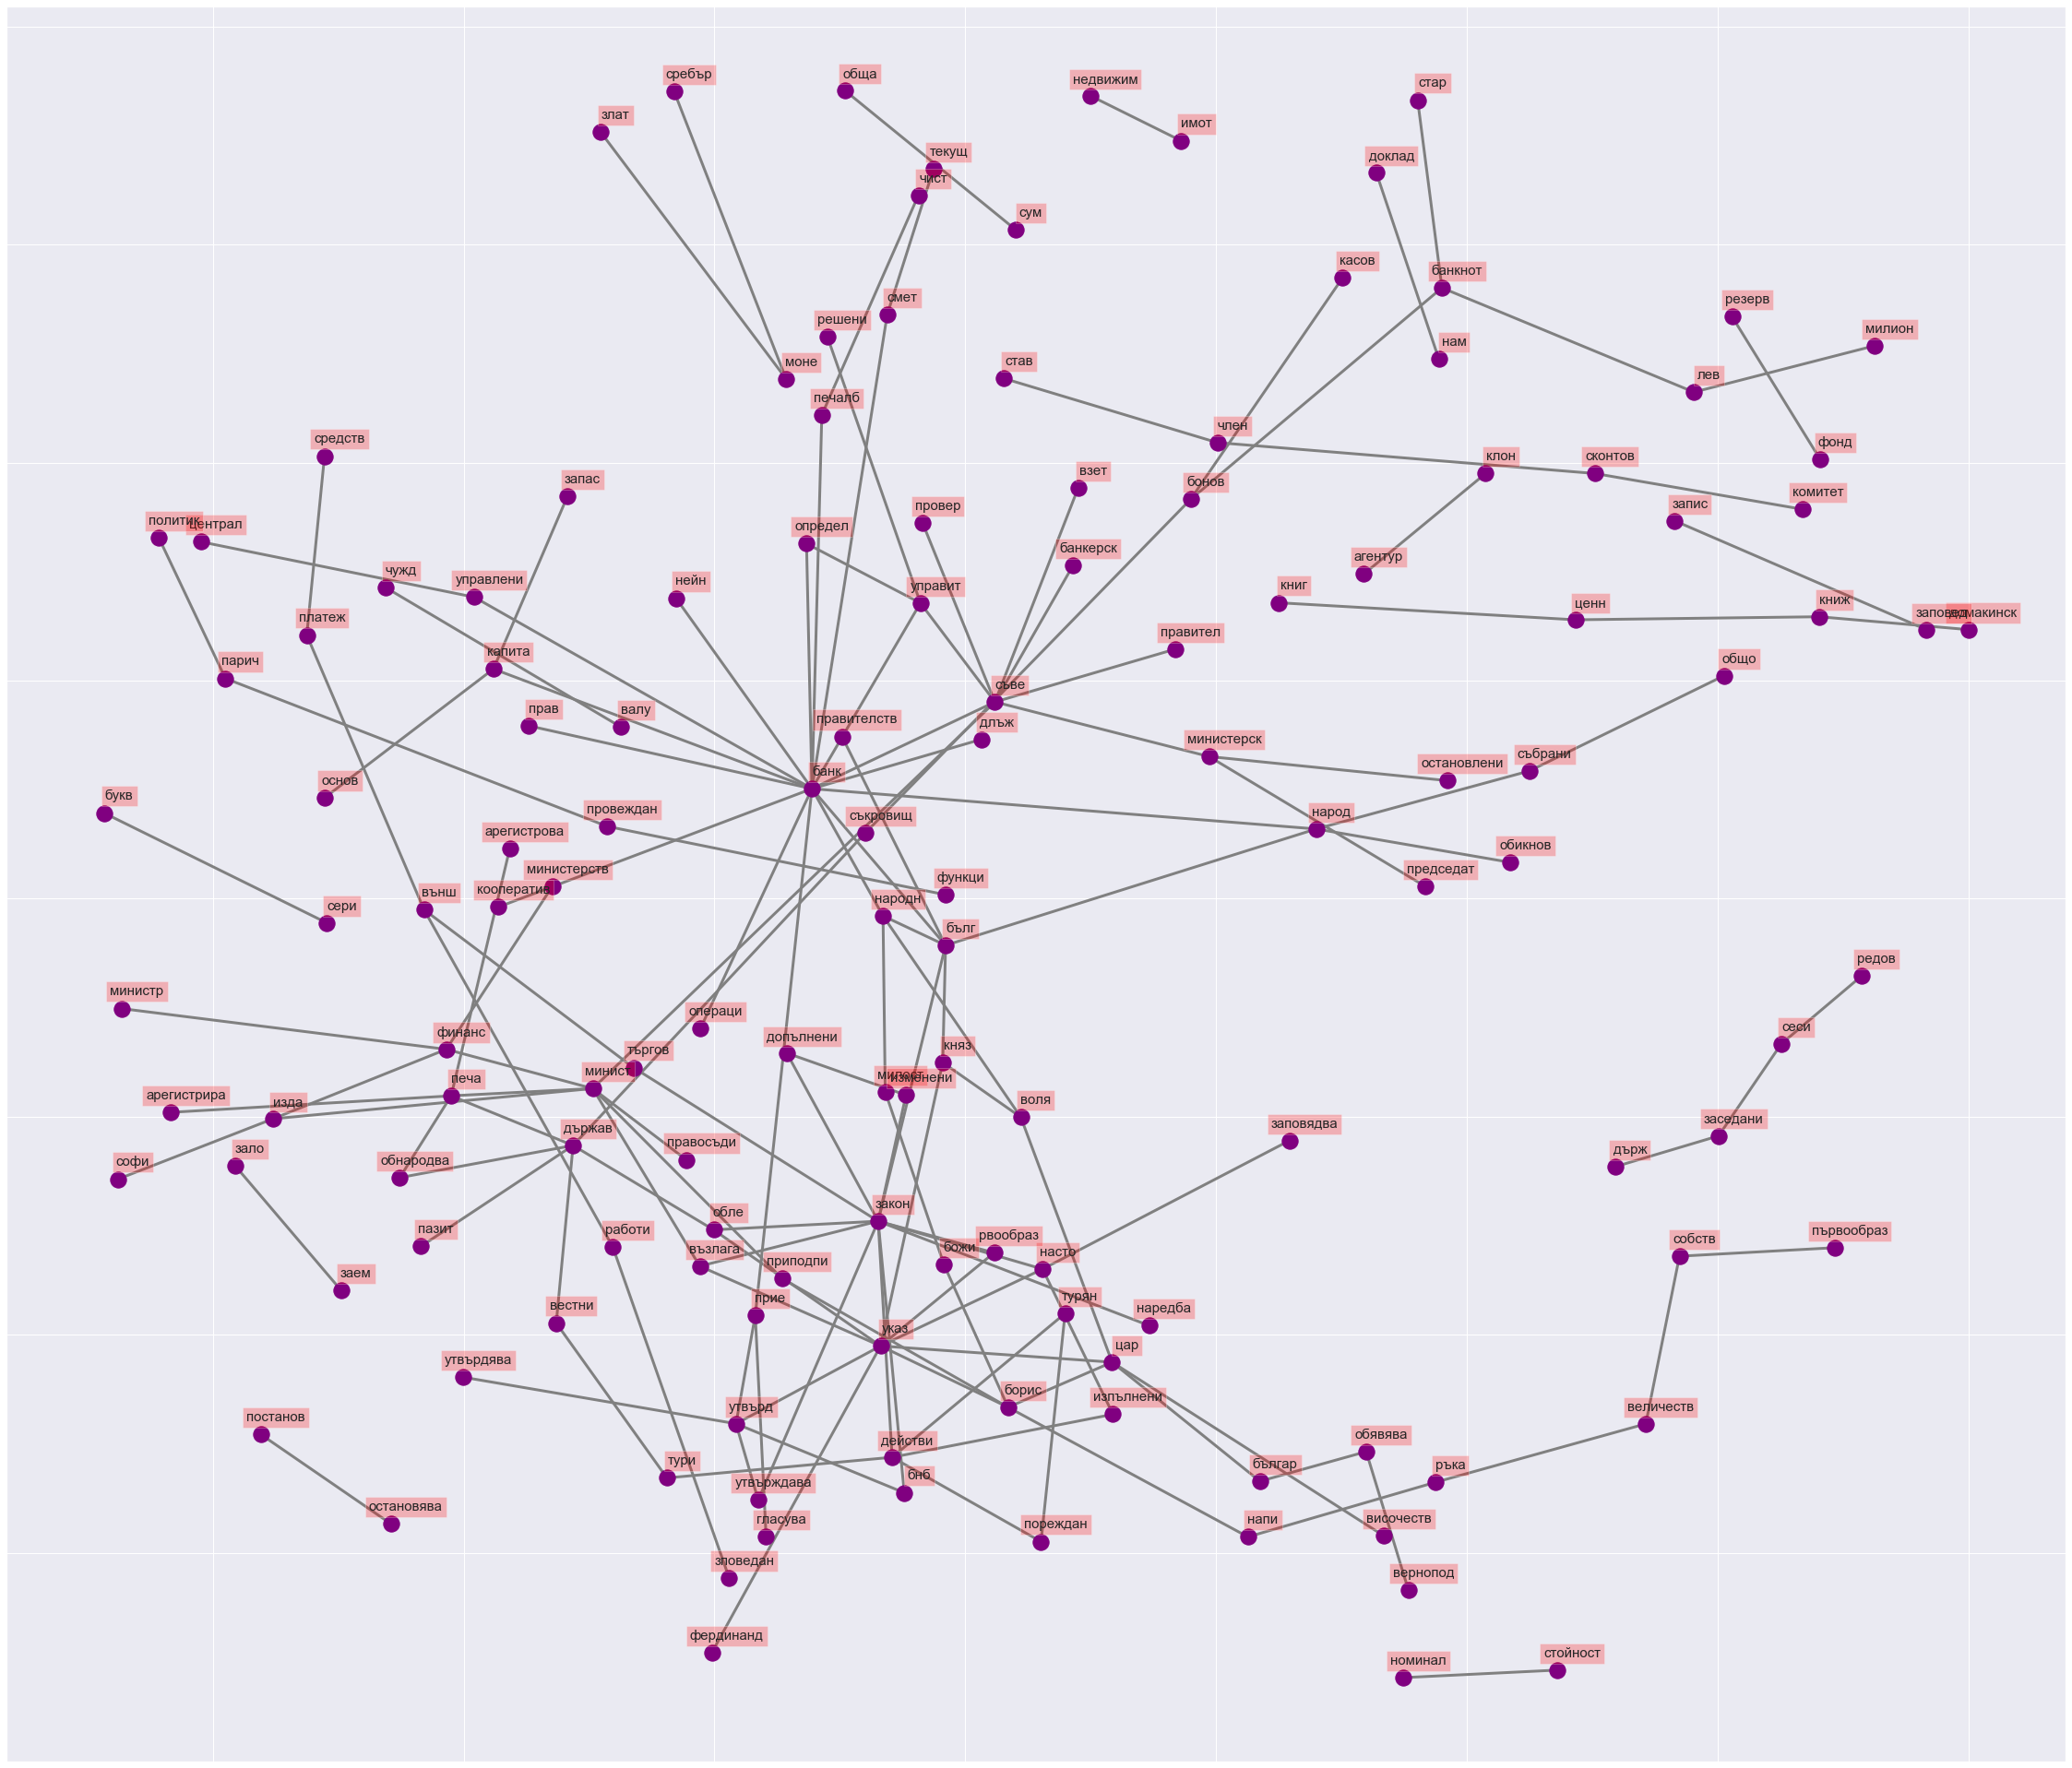

In [7]:
# Create dictionary of bigrams and their counts
d = bigramdf.set_index('bigram').T.to_dict('records')

# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(40, 35))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.015, value[1]+.015
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=15)
    
plt.show()


In [8]:
countsr = db.groupby(['Year', 'Function', 'Ruler'], as_index=False)['Text'].count()

# BNB throughout history
Тук можем да видим кои владетели и режими са развивали функциите на БНБ, както и в какво направление и през кой период. Устройствените закони и устави, например, са типични през целия период, докато функцията на банката като фискален агент е по-характеризираща за периода на Цар Борис III.

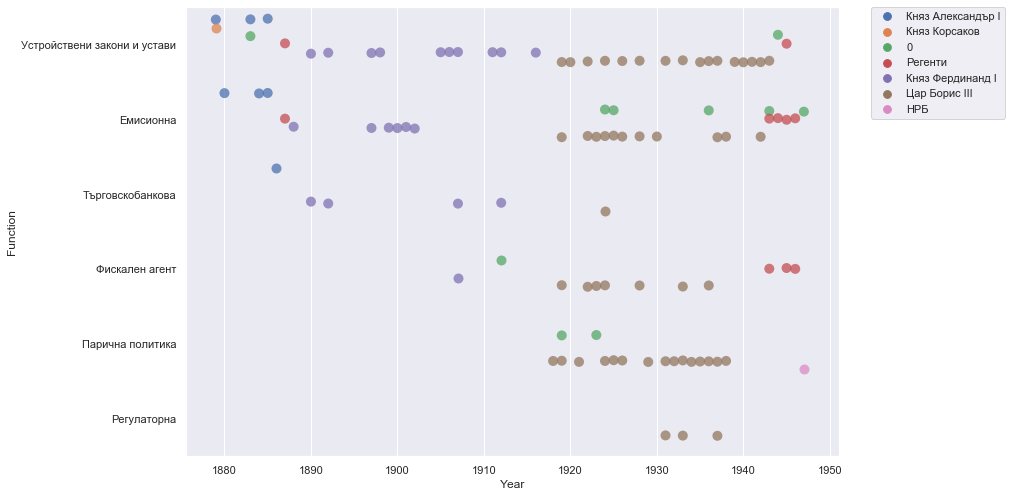

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.stripplot(x='Year', y="Function", hue="Ruler",
              data=countsr, dodge=True, alpha=.75, size = 10, zorder=1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [10]:
countsr = db.groupby(['Function'], as_index=False)['Text'].agg({'Text': ' '.join})
countsr.head()

,Function,Text
0,Емисионна,емисион функци закон прав рязане моне бълг утв...
1,Парична политика,остан член прие управит съве бълг народн банк ...
2,Регулаторна,регулатор надзор функци основаван банк открива...
3,Търговскобанкова,търговскобанк функци закон издаван бнб облигац...
4,Устройствени закони и устави,проект устав бълг народн банк утвърд руск импе...


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(countsr['Text'])

# tr-idf анализ
Индексът **tf-idf** ни показва значимостта на всяка дума към всеки документ (класифициран на база функция и след това режим) спрямо множеството от всички налични документи. Това ни подсказва кои са думите, които различните режими на управление са предпочитали да използват спрямо останалите (In15), или които преопладават при някои от функциите спрямо другите (In13).

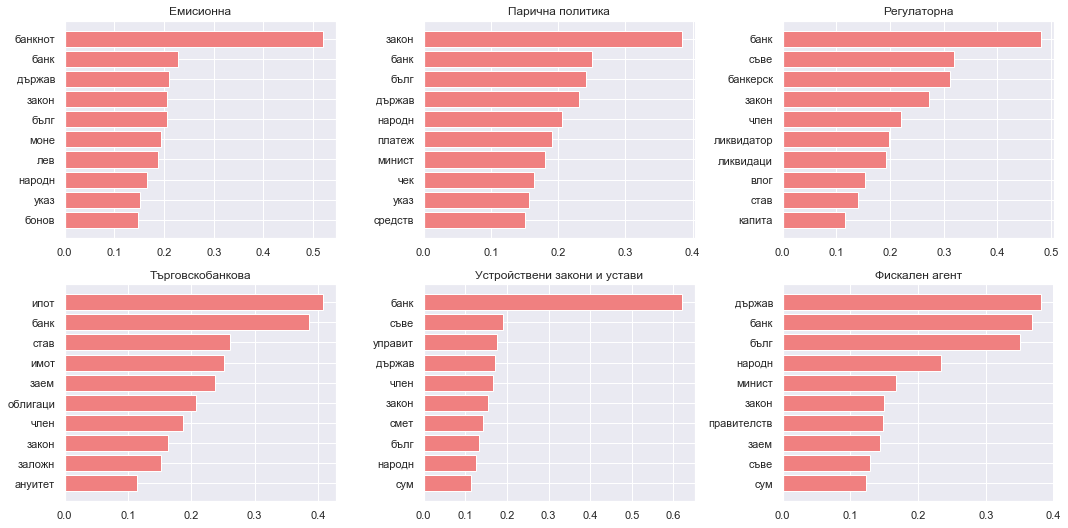

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
for i in range(0, len(countsr)):
    df = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    words = df.index[:10]
    scores = df.iloc[:10,:].values[:,0]
    axes[int(i/3), i%3].barh(np.arange(len(words)), df.iloc[:10,:].values[:,0], align='center',
        color='lightcoral', ecolor='black');
    axes[int(i/3), i%3].set_yticks(np.arange(len(words)))
    axes[int(i/3), i%3].set_yticklabels(words)
    axes[int(i/3), i%3].invert_yaxis()  # labels read top-to-bottom
    axes[int(i/3), i%3].set_title(countsr['Function'][i])

fig.tight_layout()

In [14]:
countsr = db.groupby(['Ruler'], as_index=False)['Text'].agg({'Text': ' '.join})
tfIdfVectorizer=TfidfVectorizer(use_idf=True)
tfIdf = tfIdfVectorizer.fit_transform(countsr['Text'])

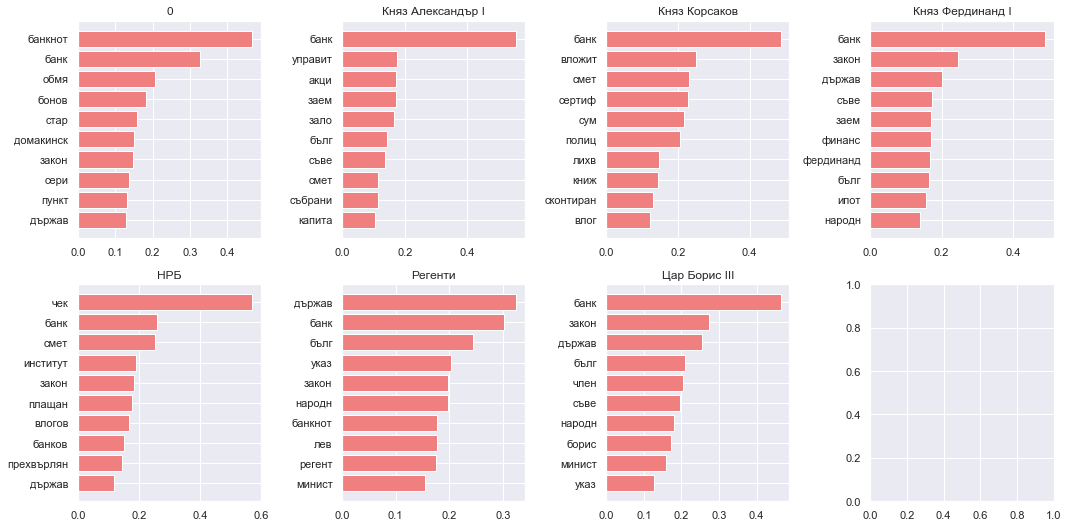

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(15, 7.5))
for i in range(0, len(countsr)):
    df = pd.DataFrame(tfIdf[i].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    words = df.index[:10]
    scores = df.iloc[:10,:].values[:,0]
    axes[int(i/4), i%4].barh(np.arange(len(words)), df.iloc[:10,:].values[:,0], align='center',
        color='lightcoral', ecolor='black');
    axes[int(i/4), i%4].set_yticks(np.arange(len(words)))
    axes[int(i/4), i%4].set_yticklabels(words)
    axes[int(i/4), i%4].invert_yaxis()  # labels read top-to-bottom
    axes[int(i/4), i%4].set_title(countsr['Ruler'][i])

fig.tight_layout()

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
count_vectorizer = CountVectorizer()
vectorizer = count_vectorizer.fit(db['Text'])
count_data = vectorizer.transform(db['Text'])

# LDA Model
* hyper-parameters (ntopics = 6 (и е 6 (съответства на броя на функциите, идентифицирани предварителнo), learning rate = 0.05 (grid-search))
* Като последна стъпка в анализа, използваме unsupervised machine learning. Алгоритъмът, който прилагаме, се нарича\textit{ latent Dirichlet allocation (LDA)} и стъпва на допускането, че един документ (в случая - закон) се отнася до повече от една тема (функция), и съответно представлява съвкупност от различни такива, а всяка тема от своя страна представлява съвкупност от думи. Алгоритъмът поема като входящи данни *торба от думи*  (от англ. - bag of words) за всеки документ (закон) и на база предварително зададени брой теми, изчислява каква е верояността всеки документ да се отнася за съответната тема и всяка дума да попада в тема. Същественото за този подход е, че \самите теми не са зададени предварително - те се извличат в рамките на модела; единствено броят им е зададен като входящи за модела данни. Можем да визуализираме темите, представяйки думите, които са с най-голяма вероятност да попаднат в тях.

In [17]:
##GRID SEARCH
# Define Search Param
ntopics = 6
search_params = {'n_components': [ntopics], 'learning_decay': [.05, .1, .2, .5, .7]}
lda = LDA()
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(lda, param_grid=search_params)
model.fit(count_data)
best_lda_model = model.best_estimator_
lda_output = best_lda_model.transform(count_data)

C:\Users\GerganaM\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


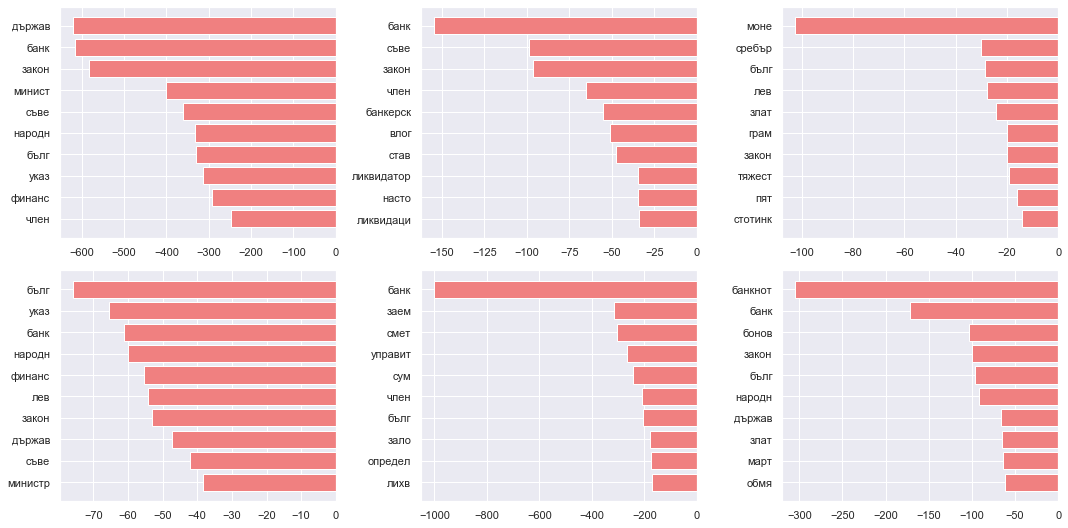

In [18]:
wordnames = np.array(vectorizer.get_feature_names())
fig, axes = plt.subplots(2, 3, figsize=(15, 7.5))
for i in range(0, 6):
    wordind = (-best_lda_model.components_[i]).argsort()[:10]
    scoresLDA = -best_lda_model.components_[i][[wordind]]
    words = wordnames.take(wordind)
    axes[int(i/3), i%3].barh(np.arange(len(words)), scoresLDA, align='center',
        color='lightcoral', ecolor='black');
    axes[int(i/3), i%3].set_yticks(np.arange(len(words)))
    axes[int(i/3), i%3].set_yticklabels(words)
    axes[int(i/3), i%3].invert_yaxis()  
   

fig.tight_layout();